```mermaid
%%{
  init: {
    'theme': 'base',
    'themeVariables': {
      'primaryColor': '#FFFFFF',
      'primaryTextColor': '#000000',
      'primaryBorderColor': '#000000',
      'lineColor': '#000000',
      'secondaryColor': '#FFFFFF',
      'tertiaryColor': '#fff',
      'clusterBkg': '#FFFFFF',
      'clusterBorder': '#000000'
    }
  }
}%%

flowchart LR

  %% User Section
  subgraph User
    researcher -->|affiliated with| institution
    researcher -->|participates in| project
    researcher -->|has account| blockchain_account
    researcher -->|collaborates with| researcher2
    researcher2
  end

  %% Project Section
  subgraph Project
    project -->|has| project_metadata
    project -->|stores| file
    project -->|created by| researcher
    project -->|linked to| blockchain_account
    project -->|associated with| institution
    project -->|has owner| project_owner
  end
  
  %% File Section
  subgraph File
    file -->|has| file_metadata
    file -->|linked to| project
    file -->|stored in| ipfs
  end
  
  %% Blockchain Section
  subgraph Blockchain
    blockchain_account -->|linked to| project
    blockchain_account -->|has attributes| project_account_attributes
    blockchain_account -->|stores CID for| file
  end
  
  %% Metadata Section
  subgraph Metadata
    project_metadata -->|describes| project
    file_metadata -->|describes| file
    project_metadata -->|has keywords| keyword
  end
  
  %% Institution Section
  subgraph Institution
    institution -->|affiliated with| researcher
    institution -->|participates in| project
  end
  
  %% IPFS Section
  subgraph IPFS
    ipfs -->|stores| file
    ipfs -->|stores| project_metadata
  end
```


Engine

In [3]:
#### New code

### Linking location and other me
import json
import networkx as nx
from pyvis.network import Network
from whoosh.index import open_dir
from whoosh.qparser import QueryParser

def build_knowledge_graph_from_projects(projects_data, search_results=None, closest_file=None):
    """Build the knowledge graph based on JSON-LD projects data."""
    G = nx.Graph()

    # Dictionary to track existing nodes for locations, keywords, and funding agencies
    location_nodes = {}
    keyword_nodes = {}
    funding_agency_nodes = {}

    # Iterate through the projects in @graph
    for project in projects_data['@graph']:
        project_id = project.get('schema:identifier', 'Unknown Project')
        project_name = project.get('schema:description', {}).get('schema:name', 'Unnamed Project')

        # Only add nodes for projects matching search results (if search_results provided)
        if search_results and project_id not in search_results:
            continue

        # Add project node with meaningful label and larger size
        G.add_node(project_id, label=project_name, type='Project', size=20, color='#3498db')

        # Link project to its owner (linked_user)
        linked_user = project.get('schema:linked_user')
        if linked_user:
            G.add_node(linked_user, label=linked_user, type='User', size=15, color='#e74c3c')
            G.add_edge(project_id, linked_user, label='Owner', color='#2c3e50', width=2)

        # Extract project description details (startDate, endDate, location)
        project_start = project['schema:description'].get('schema:startDate', 'Unknown Start Date')
        project_end = project['schema:description'].get('schema:endDate', 'Unknown End Date')

        # Add location node and link project to location
        project_location = project['schema:description'].get('schema:location', {}).get('schema:name', 'Unknown Location')
        if project_location != 'Unknown Location':
            # Check if the location already exists globally, if so, link to existing node
            if project_location not in location_nodes:
                location_nodes[project_location] = f"location_{project_location}"
                G.add_node(location_nodes[project_location], label=project_location, type='Location', size=10, color='#f39c12')
            G.add_edge(project_id, location_nodes[project_location], label='Located in', color='#f39c12', width=1.5)

        # Link project to funding agency
        funding_agency = project['schema:description'].get('schema:funding', {}).get('schema:name', 'Unknown Funding Agency')
        if funding_agency != 'Unknown Funding Agency':
            # Check if the funding agency already exists globally, if so, link to existing node
            if funding_agency not in funding_agency_nodes:
                funding_agency_nodes[funding_agency] = f"funding_{funding_agency}"
                G.add_node(funding_agency_nodes[funding_agency], label=funding_agency, type='FundingAgency', size=10, color='#e74c3c')
            G.add_edge(project_id, funding_agency_nodes[funding_agency], label='Funded by', color='#c0392b', width=1.5)

        # Link project to keywords
        keywords = project['schema:description'].get('schema:keywords', [])
        for keyword in keywords:
            # Check if the keyword already exists globally, if so, link to existing node
            if keyword not in keyword_nodes:
                keyword_nodes[keyword] = f"keyword_{keyword}"
                G.add_node(keyword_nodes[keyword], label=keyword, type='Keyword', size=4, color='#8e44ad')
            G.add_edge(project_id, keyword_nodes[keyword], label='Has Keyword', color='#8e44ad', width=1.5)

        # Link project to its files
        files = project.get('schema:files', [])
        for file_info in files:
            file_cid = file_info.get('file_cid', 'Unknown File')
            file_title = file_info['metadata'].get('dc:title', 'Untitled File')

            # Determine if this file is the closest match
            is_closest_file = file_cid == closest_file

            # Set visual emphasis for the closest matching file
            file_color = '#e67e22' if is_closest_file else '#9b59b6'
            file_size = 15 if is_closest_file else 10

            # Add file node with file title and metadata CID
            G.add_node(file_cid, label=file_title, type='File', size=file_size, color=file_color)
            G.add_edge(project_id, file_cid, label='Has File', color='#8e44ad', width=2)

            # Add metadata CID node and link to file
            metadata_cid = file_info.get('metadata_cid', 'Unknown Metadata')
            G.add_node(metadata_cid, label=f"Metadata: {metadata_cid}", type='Metadata', size=8, color='#2ecc71')
            G.add_edge(file_cid, metadata_cid, label='Has Metadata', color='#27ae60', width=1.5)

    return G


def visualize_graph_with_legend(G):
    """Visualize the knowledge graph using pyvis with a legend and improved styling."""
    net = Network(notebook=True, height='750px', width='100%', cdn_resources='in_line')  # Set size and use inline resources for Jupyter
    net.barnes_hut(gravity=-4000)  # Use a force-directed layout for better spacing

    # Custom options for better visual clarity
    net.set_options("""
    var options = {
      "nodes": {
        "shape": "dot",
        "font": {
          "size": 16
        }
      },
      "edges": {
        "smooth": {
          "type": "continuous"
        },
        "color": {
          "inherit": false
        },
        "width": 1.5
      },
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -4000,
          "springLength": 100,
          "springConstant": 0.01,
          "avoidOverlap": 0.1
        },
        "minVelocity": 0.75
      }
    }
    """)

    # Adding the main graph from NetworkX
    net.from_nx(G)
    
    # Adding a legend to the graph for visual clarity
    legend = """
    <div style="position:absolute; top:10px; right:10px; background-color:white; padding:10px; border-radius:5px; box-shadow:0 0 10px rgba(0,0,0,0.5);">
        <h3>Knowledge Graph Legend</h3>
        <ul style="list-style:none; padding:0;">
            <li><span style="background-color:#3498db; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Project</strong></li>
            <li><span style="background-color:#e74c3c; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>User</strong></li>
            <li><span style="background-color:#e67e22; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Highlighted File</strong></li>
            <li><span style="background-color:#9b59b6; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>File</strong></li>
            <li><span style="background-color:#2ecc71; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Metadata</strong></li>
            <li><span style="background-color:#1abc9c; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Duration</strong></li>
            <li><span style="background-color:#f39c12; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Location</strong></li>
            <li><span style="background-color:#c0392b; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Funding Agency</strong></li>
            <li><span style="background-color:#8e44ad; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Keyword</strong></li>
        </ul>
        <h4>Edge Labels</h4>
        <ul style="list-style:none; padding:0;">
            <li><strong>Owner</strong> - Links project to its owner</li>
            <li><strong>Has File</strong> - Links project to its files</li>
            <li><strong>Has Metadata</strong> - Links file to its metadata</li>
            <li><strong>Located in</strong> - Links project to its location</li>
            <li><strong>Funded by</strong> - Links project to its funding agency</li>
            <li><strong>Has Keyword</strong> - Links project to its keywords</li>
        </ul>
    </div>
    """
    
    net.show("knowledge_graph.html")  # Show the network in a browser
    
    # Return the HTML legend as well
    return legend

def search_projects(query, index_dir):
    """Search for projects in the indexed metadata using Whoosh."""
    ix = open_dir(index_dir)
    qp = QueryParser("content", ix.schema)

    with ix.searcher() as searcher:
        query = qp.parse(query)
        results = searcher.search(query)
        search_results = [result['schema:identifier'] for result in results]
        return search_results

def find_closest_file(query_str, projects_data):
    """Find the file with the closest match to the query."""
    closest_file = None
    highest_score = 0
    
    for project in projects_data['@graph']:
        files = project.get('schema:files', [])
        for file_info in files:
            file_title = file_info['metadata'].get('dc:title', '')
            score = len(set(query_str.lower().split()) & set(file_title.lower().split()))  # Simple overlap score
            if score > highest_score:
                highest_score = score
                closest_file = file_info.get('file_cid')

    return closest_file

def main(query, projects_file, index_dir):
    """Main execution function."""
    with open(projects_file, 'r') as f:
        projects_data = json.load(f)
    
    # Search for projects that match the query
    search_results = search_projects(query, index_dir)
    
    # Find the closest matching file
    closest_file = find_closest_file(query, projects_data)
    
    # Build the knowledge graph
    G = build_knowledge_graph_from_projects(projects_data, search_results, closest_file)
    
    # Visualize the graph with a legend
    visualize_graph_with_legend(G)

# Example usage
query = "sábado"  # replace with actual search term
projects_file = "datasets/projects.json"  # replace with your actual projects file path
index_dir = "indexdir"  # replace with your actual index directory path
main(query, projects_file, index_dir)



knowledge_graph.html


In [11]:
#### Focus on the 
import json
import networkx as nx
from pyvis.network import Network
from whoosh.index import open_dir
from whoosh.qparser import QueryParser

def build_knowledge_graph_from_projects(projects_data, search_results=None, closest_file=None, query_keyword=None):
    """Build the knowledge graph based on JSON-LD projects data."""
    G = nx.Graph()

    # Dictionary to track existing nodes for locations, keywords, and funding agencies
    location_nodes = {}
    keyword_nodes = {}
    funding_agency_nodes = {}

    # Iterate through the projects in @graph
    for project in projects_data['@graph']:
        project_id = project.get('schema:identifier', 'Unknown Project')
        project_name = project.get('schema:description', {}).get('schema:name', 'Unnamed Project')

        # Only add nodes for projects matching search results (if search_results provided)
        if search_results and project_id not in search_results:
            continue

        # Emphasize the project most closely related to the query_keyword
        is_closest_project = query_keyword and query_keyword.lower() in project_name.lower()

        # Add project node with larger size and distinct color for the closest match
        project_color = '#f1c40f' if is_closest_project else '#3498db'
        project_size = 30 if is_closest_project else 20
        G.add_node(project_id, label=project_name, type='Project', size=project_size, color=project_color)

        # Link project to its owner (linked_user)
        linked_user = project.get('schema:linked_user')
        if linked_user:
            G.add_node(linked_user, label=linked_user, type='User', size=15, color='#e74c3c')
            G.add_edge(project_id, linked_user, label='Owner', color='#2c3e50', width=2)

        # Extract project description details (startDate, endDate, location)
        project_start = project['schema:description'].get('schema:startDate', 'Unknown Start Date')
        project_end = project['schema:description'].get('schema:endDate', 'Unknown End Date')

        # Add location node and link project to location
        project_location = project['schema:description'].get('schema:location', {}).get('schema:name', 'Unknown Location')
        if project_location != 'Unknown Location':
            # Check if the location already exists globally, if so, link to existing node
            if project_location not in location_nodes:
                location_nodes[project_location] = f"location_{project_location}"
                G.add_node(location_nodes[project_location], label=project_location, type='Location', size=10, color='#f39c12')
            G.add_edge(project_id, location_nodes[project_location], label='Located in', color='#f39c12', width=1.5)

        # Link project to funding agency
        funding_agency = project['schema:description'].get('schema:funding', {}).get('schema:name', 'Unknown Funding Agency')
        if funding_agency != 'Unknown Funding Agency':
            # Check if the funding agency already exists globally, if so, link to existing node
            if funding_agency not in funding_agency_nodes:
                funding_agency_nodes[funding_agency] = f"funding_{funding_agency}"
                G.add_node(funding_agency_nodes[funding_agency], label=funding_agency, type='FundingAgency', size=10, color='#e74c3c')
            G.add_edge(project_id, funding_agency_nodes[funding_agency], label='Funded by', color='#c0392b', width=1.5)

        # Link project to keywords
        keywords = project['schema:description'].get('schema:keywords', [])
        for keyword in keywords:
            # Check if the keyword already exists globally, if so, link to existing node
            if keyword not in keyword_nodes:
                keyword_nodes[keyword] = f"keyword_{keyword}"
                G.add_node(keyword_nodes[keyword], label=keyword, type='Keyword', size=4, color='#8e44ad')
            G.add_edge(project_id, keyword_nodes[keyword], label='Has Keyword', color='#8e44ad', width=1.5)

        # Link project to its files
        files = project.get('schema:files', [])
        for file_info in files:
            file_cid = file_info.get('file_cid', 'Unknown File')
            file_title = file_info['metadata'].get('dc:title', 'Untitled File')

            # Determine if this file is the closest match
            is_closest_file = file_cid == closest_file

            # Set visual emphasis for the closest matching file
            file_color = '#e67e22' if is_closest_file else '#9b59b6'
            file_size = 15 if is_closest_file else 10

            # Add file node with file title and metadata CID
            G.add_node(file_cid, label=file_title, type='File', size=file_size, color=file_color)
            G.add_edge(project_id, file_cid, label='Has File', color='#8e44ad', width=2)

            # Add metadata CID node and link to file
            metadata_cid = file_info.get('metadata_cid', 'Unknown Metadata')
            G.add_node(metadata_cid, label=f"Metadata: {metadata_cid}", type='Metadata', size=8, color='#2ecc71')
            G.add_edge(file_cid, metadata_cid, label='Has Metadata', color='#27ae60', width=1.5)

    return G


def visualize_graph_with_legend(G):
    """Visualize the knowledge graph using pyvis with a legend and improved styling."""
    net = Network(notebook=True, height='750px', width='100%', cdn_resources='in_line')  # Set size and use inline resources for Jupyter
    net.barnes_hut(gravity=-4000)  # Use a force-directed layout for better spacing

    # Custom options for better visual clarity
    net.set_options("""
    var options = {
      "nodes": {
        "shape": "dot",
        "font": {
          "size": 16
        }
      },
      "edges": {
        "smooth": {
          "type": "continuous"
        },
        "color": {
          "inherit": false
        },
        "width": 1.5
      },
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -4000,
          "springLength": 100,
          "springConstant": 0.01,
          "avoidOverlap": 0.1
        },
        "minVelocity": 0.75
      }
    }
    """)

    # Adding the main graph from NetworkX
    net.from_nx(G)
    
    # Adding a legend to the graph for visual clarity
    legend = """
    <div style="position:absolute; top:10px; right:10px; background-color:white; padding:10px; border-radius:5px; box-shadow:0 0 10px rgba(0,0,0,0.5);">
        <h3>Knowledge Graph Legend</h3>
        <ul style="list-style:none; padding:0;">
            <li><span style="background-color:#3498db; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Project</strong></li>
            <li><span style="background-color:#f1c40f; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Highlighted Project (Keyword Match)</strong></li>
            <li><span style="background-color:#e74c3c; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>User</strong></li>
            <li><span style="background-color:#e67e22; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Highlighted File</strong></li>
            <li><span style="background-color:#9b59b6; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>File</strong></li>
            <li><span style="background-color:#2ecc71; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Metadata</strong></li>
            <li><span style="background-color:#1abc9c; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Duration</strong></li>
            <li><span style="background-color:#f39c12; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Location</strong></li>
            <li><span style="background-color:#c0392b; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Funding Agency</strong></li>
            <li><span style="background-color:#8e44ad; padding:5px; border-radius:50%; display:inline-block; width:15px; height:15px; margin-right:5px;"></span> <strong>Keyword</strong></li>
        </ul>
    </div>
    """
    
    # Inject the legend HTML into the pyvis graph
    net.html = net.html.replace("</body>", legend + "</body>")  
    return net.show("knowledge_graph.html")


def search_projects(keyword, index_dir):
    """Search for projects based on a keyword using Whoosh index."""
    ix = open_dir(index_dir)
    with ix.searcher() as searcher:
        query = QueryParser("content", ix.schema).parse(keyword)
        results = searcher.search(query, limit=10)
        return [result['project_id'] for result in results]


# Example usage:

PROJECTS_JSON = 'datasets/projects.json'
INDEX_DIR = 'indexdir'

# Load your JSON-LD file
with open(PROJECTS_JSON, 'r') as f:
    projects_data = json.load(f)

# Perform a keyword search (replace 'index_dir' with your actual index directory)
keyword = 'climate'
search_results = search_projects(keyword, INDEX_DIR)

# Build the graph with the search results and visualize
G = build_knowledge_graph_from_projects(projects_data, search_results=search_results, query_keyword=keyword)
visualize_graph_with_legend(G)


knowledge_graph.html


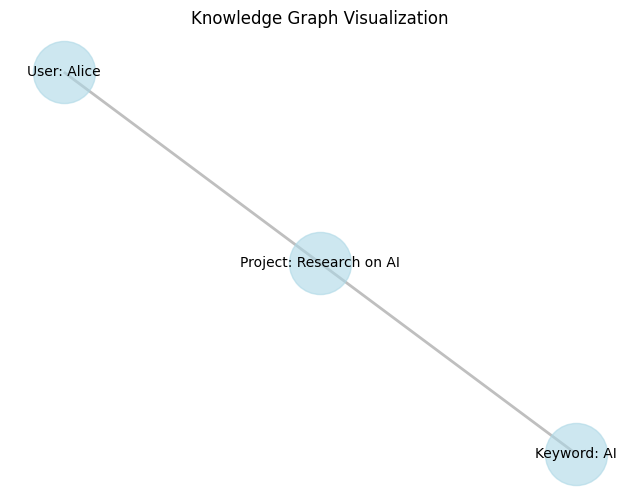

,Name,Description
0,User: Alice,User: Alice (User)
1,Project: Research on AI,Project: Research on AI (Project)
2,Keyword: AI,Keyword: AI (Keyword)


In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Create the knowledge graph
def create_sample_knowledge_graph():
    G = nx.Graph()
    G.add_node("User: Alice", type="User")
    G.add_node("Project: Research on AI", type="Project")
    G.add_node("Keyword: AI", type="Keyword")
    
    G.add_edge("User: Alice", "Project: Research on AI", label="manages")
    G.add_edge("Project: Research on AI", "Keyword: AI", label="has keyword")
    
    return G

# Draw the graph
def draw_graph(G):
    pos = nx.spring_layout(G)  # positions for all nodes
    plt.figure(figsize=(8, 6))
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    plt.title("Knowledge Graph Visualization")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Search results
search_results = [
    ("User: Alice", "User: Alice (User)"),
    ("Project: Research on AI", "Project: Research on AI (Project)"),
    ("Keyword: AI", "Keyword: AI (Keyword)")
]

# Create the knowledge graph and visualize it
G = create_sample_knowledge_graph()
draw_graph(G)

# Convert search results to a DataFrame
df_results = pd.DataFrame(search_results, columns=["Name", "Description"])

# Display results
df_results

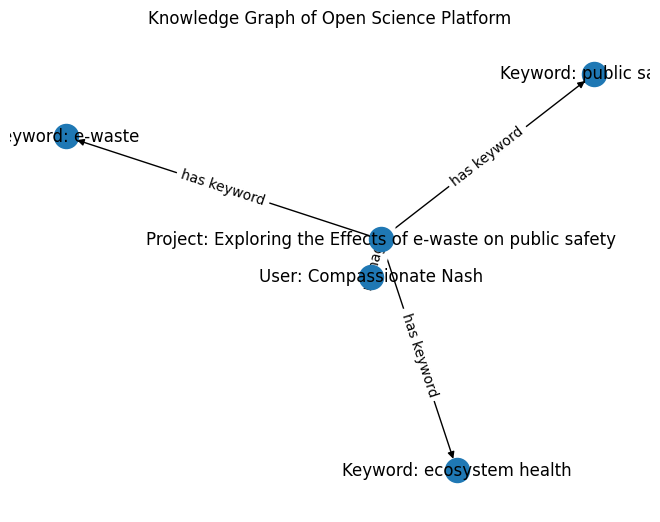

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample JSON-LD data
jsonld_data = {
    "@context": {
        "User": "https://schema.org/Person",
        "Project": "https://schema.org/CreativeWork",
        "Keyword": "https://schema.org/keywords"
    },
    "@graph": [
        {
            "@type": "User",
            "name": "Compassionate Nash",
            "email": "compassionate_nash@email.com",
            "affiliation": "Ecole Nationale Supérieure des Arts et Industries Textile",
            "role": "author"
        },
        {
            "@type": "Project",
            "title": "Exploring the Effects of e-waste on public safety",
            "abstract": "This study aims to investigate the effects of e-waste on public safety and propose strategies for improvement.",
            "startDate": "2019-11-06",
            "endDate": "2022-01-28",
            "funder": "European Union Horizon 2020",
            "keywords": ["e-waste", "public safety", "ecosystem health"]
        }
    ]
}

# Create a new directed graph
G = nx.DiGraph()

# Add User node
user_data = jsonld_data['@graph'][0]
user_node = f"User: {user_data['name']}"
G.add_node(user_node, type='User')

# Add Project node
project_data = jsonld_data['@graph'][1]
project_node = f"Project: {project_data['title']}"
G.add_node(project_node, type='Project')

# Add Keyword nodes
for keyword in project_data['keywords']:
    keyword_node = f"Keyword: {keyword}"
    G.add_node(keyword_node, type='Keyword')
    G.add_edge(project_node, keyword_node, label='has keyword')

# Add edge from User to Project
G.add_edge(user_node, project_node, label='manages')

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_edge_attributes(G, 'label')

nx.draw(G, pos, with_labels=True, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Knowledge Graph of Open Science Platform")
plt.show()
